# Latent Dirichlet Allocation for Topic Modelling on Customer Reviews: The case of UK Delivery Companies 

**Author: Georgios Spyrou (https://github.com/gpsyrou)**

_Last Update: 22/05/2021_

<img src="../img/projectimage.png" alt="Sentiment Picture" width="820" height="640">

### Sections
- <a href="#project_idea" style="text-decoration: none"> Project Description</a>
- <a href="#data_retrieval" style="text-decoration: none"> Web-Scrapping Tool and Data Retrieval</a>
- <a href="#data_cleaning_eda" style="text-decoration: none"> Data Cleaning & Initial Exploratory Data Analysis (EDA)</a>
    - <a href="#data_preprocessing" style="text-decoration: none"> Data Preprocessing </a>
    - <a href="#eda" style="text-decoration: none"> Exploratory Data Analysis </a>
- <a href="#lda" style="text-decoration: none"> Latent Dirichlet Allocation model </a>

<a id='project_idea'></a>
### Introduction

In this project we are going to explore the world of logistic companies and the issues that they might be facing. Specifically, we are going to focus on analyzing data regarding a few of the most well-known delivery companies in the UK, namely <a href="https://en.wikipedia.org/wiki/Deliveroo" style="text-decoration:none"> Deliveroo</a>, <a href="https://en.wikipedia.org/wiki/UberEats" style="text-decoration:none"> UberEats</a>, <a href="https://en.wikipedia.org/wiki/Just_Eat" style="text-decoration:none"> Just Eat</a> and <a href="https://stuart.com/" style="text-decoration:none"> Stuart</a>. To do that we are going to utilize the internet and the reviews that we can find in many different platforms, especially these platforms that are specializing at collecting reviews and opininions of customers for a plethora of companies and services. 

The first iteration of this project it's using the reviews that can be found in the famous consumer review website <a href="https://en.wikipedia.org/wiki/Trustpilot" style="text-decoration:none"> TrustPilot</a>. Even though the website is already providing some API functionalities, we are going to write our own web-scraping tool to retrieve the data in the format that we want. We will attempt to collect as many reviews as possible and then use them to identify interesting findings in the text. For example, we will try to identify what is the sentiment across all reviews for a specific company, what are the most common words and bigrams (i.e. pairs of words that tend to appear next to each other) in the reviews, and more. Finally, we will implement a <a href="https://en.wikipedia.org/wiki/Latent_Dirichlet_allocation" style="text-decoration:none"> Latent Dirichlet Allocation</a> model to try and identify what are the topics that these reviews correspond to.


We are going to discuss the specifics in more depth as we are going through the different parts of the project. As a starting point of course, we need to collect the relevant reviews for the aforementioned group of delivery companies.

<a id='data_retrieval'></a>
### Web-Scrapping Tool and Data Retrieval

In order to collect the reviews directly from the TrustPilot website, we have created a web-scrapping tool that allowed us to automate this process across different companies & their corresponding reviews. This tool is iterating across different pages of the website and collects the reviews and any other relevant information, with the output being stored in csv files. Moreover, we have packaged the tool into a python library. Hence, if you are thinking of working on a similar project where you need to retrieve data from TrustPilot, you can install the package that you can find <a href="https://github.com/gpsyrou/Text_Analysis_of_Consumer_Reviews/blob/main/trustplt.py" style="text-decoration:none">here</a>. As of May 2021, the package contains the main functionalities to collect many different information from the website, like the reviews, reviewer_id, date of the review, user rating, and more. 

For the first iteration of the project, we have built the aforementioned package with the functionality to retrieve the following information - which will also be the features in our dataset:

1. **Company**: Name of the Company that we are examining (e.g. Deliveroo, UberEats, JustEat, Stuart)
2. **Id**: The unique identifier for the Review
3. **Reviewer_Id**: Unique id for a reviewer/user
4. **Title**: Title of the review
5. **Review**: The text corresponding to the review submitted from the reviewer
6. **Date**: Day of review submission
7. **Rating**: The rating about the company, as submitted from the reviewer

Thus, after collecting the data and save them in a CSV format, we can by having a first look at the data and familiarize ourselves with the features. 

In [37]:
import os
import string
import numpy as np
import pandas as pd
from typing import List
from collections import Counter

import matplotlib.pyplot as plt
import seaborn as sns

project_dir = r'D:\GitHub\Projects\Analysis_of_Delivery_Companies_Reviews'
os.chdir(project_dir)

In [2]:
reviews_base_file = os.path.join(project_dir, 'reviews.csv')

In [3]:
col_names = ['Company', 'Id', 'Reviewer_Id', 'Title', 'Review', 'Date', 'Rating']
ratings_dict = {1: 'Bad', 2: 'Poor', 3: 'Average', 4: 'Great', 5: 'Excellent'}      

base_df = pd.read_csv(reviews_base_file, sep=',')

<a id='data_cleaning_eda'></a>
### Data Cleaning & Exploratory Data Analysis

Here we can have an initial look about the information contained in the dataset - Please note that each row in the dataset corresponds to a different _review_ :

In [4]:
base_df.head()

,Company,Id,Reviewer_Id,Title,Review,Date,Rating
0,Deliveroo,60709f95f85d75087052ff8b,60709f8f0a30fd001b06dc52,Ordered food and apparently the driver…,Ordered food and apparently the driver was wai...,2021-04-09 18:40,{2: 'Poor'}
1,Deliveroo,60708710f85d75087052c89b,6070870c2158190019b3ab8e,Disgusting Live Customer Service CHAT!!!,I received standard bag of buttons that cost £...,2021-04-09 16:55,{1: 'Bad'}
2,Deliveroo,60707b91f85d75087052abb6,602eb3ac49aeca0019ad4b70,Just had an appalling experience with…,Just had an appalling experience with delivero...,2021-04-09 16:06,{1: 'Bad'}
3,Deliveroo,60705919f85d7508705251d4,60705856348d93001ad1ca1f,The same situation happened twice,The same situation happened twice. I ordered f...,2021-04-09 13:39,{2: 'Poor'}
4,Deliveroo,60705138f85d750870523d4d,6070512519dc76001aebe4b1,Driver left without giving us food,Driver turned up late couldn’t find us and lef...,2021-04-09 13:06,{1: 'Bad'}


We can see that the _Title_ of the review sometimes seems to correspond to the first few words/lines of the full _Review_, while some other times appears to be a small summary. At the same time we can observe that the _Rating_ provides us with some useful information about how the Reviewer felt regarding the company's service on that specific occasion.

In [5]:
print(f'There are {base_df.shape[0]} reviews (rows) and {base_df.shape[1]} features in the dataset')

There are 16640 reviews (rows) and 7 features in the dataset


In [6]:
base_df['Company'].value_counts()

UberEats     8240
Deliveroo    6160
JustEat      2040
Stuart        200
Name: Company, dtype: int64

We can check if there are any missing values in the dataset, or if there are rows that are duplicates:

In [7]:
num_duplicate_reviews = base_df.duplicated('Id').sum()
print(f'There are {num_duplicate_reviews} duplicate reviews in the dataset')

There are 57 duplicate reviews in the dataset


In [8]:
base_df.drop_duplicates(inplace=True)
base_df.duplicated('Id').sum()

0

In [9]:
pd.DataFrame(base_df.isna().sum(), columns=['Missing_Values'])

,Missing_Values
Company,0
Id,0
Reviewer_Id,0
Title,0
Review,224
Date,2886
Rating,0


From the queries above we can quickly see that initially we had some issues as there were 57 duplicate reviews, but we have used a pandas built-in function to remove them from the dataset. The duplication is caused due to the nature of retrieving data from by using the API, as we might process pages that we have already processed in the past, and that means retrieving the same reviews as before. Luckily, the _Id_ column is sufficient to identify unique reviews in the dataset, and hence it's easy to spot and fix duplication issues.

Now, regarding the missing values there are a few cases where Review appears to be empty, as well as quite a few cases on missing dates. The later is not a massive issue at this stage of the project. On the other hand, the absence of reviews can be a big issue as this project is all about analyzing customer reviews, and hence rows that have no text corresponding to a review wouldn't provide much information. That said, as we saw above there is another feature (_Title_) which we can use as text for rows where the _Review_ is empty.

In [10]:
empty_reviews_sample = base_df[base_df['Review'].isnull()].head(5)
empty_reviews_sample

,Company,Id,Reviewer_Id,Title,Review,Date,Rating
45,Deliveroo,60684978f85d75087045ed91,60684973402b0e001a95af2d,Great service,NaN,2021-04-03 10:54,{5: 'Excellent'}
94,Deliveroo,606221b3f85d7508703c730e,5d73f4f179586ed7bad49d52,Very very disappointed bad service,NaN,2021-03-29 18:51,{1: 'Bad'}
114,Deliveroo,605f8f5df85d7508703919f5,5e8d9b9a6251456b37ed292e,CRAP nothing else to say!,NaN,2021-03-27 20:02,{1: 'Bad'}
137,Deliveroo,605e40ddf85d750870377a98,605cb15ead7256001bdc3948,A MILLION TIMES BETTER THAN UBER EATS,NaN,2021-03-26 20:15,{5: 'Excellent'}
201,Deliveroo,6054f264f85d750bf4f97e45,5d57f496959de5789bc062bd,Better to use Uber eats,NaN,2021-03-19 18:50,{1: 'Bad'}


Apply the transformation

In [11]:
base_df.loc[base_df['Review'].isnull(), 'Review'] = base_df['Title']

and we can see how the transformation affected the dataset

In [12]:
base_df.iloc[list(empty_reviews_sample.index)]

,Company,Id,Reviewer_Id,Title,Review,Date,Rating
45,Deliveroo,60684978f85d75087045ed91,60684973402b0e001a95af2d,Great service,Great service,2021-04-03 10:54,{5: 'Excellent'}
94,Deliveroo,606221b3f85d7508703c730e,5d73f4f179586ed7bad49d52,Very very disappointed bad service,Very very disappointed bad service,2021-03-29 18:51,{1: 'Bad'}
114,Deliveroo,605f8f5df85d7508703919f5,5e8d9b9a6251456b37ed292e,CRAP nothing else to say!,CRAP nothing else to say!,2021-03-27 20:02,{1: 'Bad'}
137,Deliveroo,605e40ddf85d750870377a98,605cb15ead7256001bdc3948,A MILLION TIMES BETTER THAN UBER EATS,A MILLION TIMES BETTER THAN UBER EATS,2021-03-26 20:15,{5: 'Excellent'}
201,Deliveroo,6054f264f85d750bf4f97e45,5d57f496959de5789bc062bd,Better to use Uber eats,Better to use Uber eats,2021-03-19 18:50,{1: 'Bad'}


In [13]:
pd.DataFrame(base_df.isna().sum(), columns=['Missing_Values'])

,Missing_Values
Company,0
Id,0
Reviewer_Id,0
Title,0
Review,0
Date,2886
Rating,0


<a id='data_preprocessing'></a>
### Data Preprocessing

Now that we have familiarized a bit ourselves with the dataset and it's format, as well as conducted the initial data cleaning, we will move to one of the most important steps in any project - the data preprocessing. This section is especially important for cases where we have to deal with analysis of text, such as in this project. The reason is that text in raw format usually contains a lot of noise. This could later affect the performance of the algorithms - both in terms of computational power and the final output - due to very high dimensions of the dataset. This is happening as, like we are going to see soon, each unique word in each review will become a separate feature in the dataset. Hence, the more reviews we have the more unique words we gonna end up with in the final dataset before the analysis. 
 
Therefore, its essential to use  some common text preprocessing techniques to reduce the dimensions. As a summary, we are going to perform the following steps:

 1) Perform **tokenization** of the reviews. This is a technique of transforming a sentence, into a list of words. For example, the sentence "my order was great" would become '['my', 'order', 'was', 'great'].
 
 2) Remove from the reviews tokens that are **stopwords**. Stopwords are words inside text that do not provide much information and are usually getting removed from the initial sentence. Such words can be words like "the", "a", and more.
 
 3) Remove tokens that correspond to **punctuation** marks (e.g. "!", "?") and **numbers**.
 
 4) <a href="https://en.wikipedia.org/wiki/Stemming" style="text-decoration:none">Stemming</a> and <a href="https://en.wikipedia.org/wiki/Lemmatisation" style="text-decoration:none">Lemmatization</a>: These two methods are being used to transform a token into it's stem or lemma respectively. These two techniques help drammatically with the reduction of the dimensions as words end up being "grouped" under a specific form. In this project we are going to use lemmatization, as in general is a more advanced method compared to stemming, as lemmatization algorithms try to identify the part of speech of the token, and thus in some way they are preserving the meaning of the word (something that does not necessarily happen with stemming).
 
Below we are going to perform all of these steps to get a "cleaner" version of the reviews:

In [14]:
from nltk.corpus import stopwords

stopwords_ls = stopwords.words('english')
stopwords_ls.extend(['\'d', '\'m', '\'s', '\'ve', '\'re', '\'ll', 'n\'t', '’'])

Except the common english stopwords, it's necessary to enhance the list with some additional tokens that we want to exclude from the reviews. These are usually words that we would expect that are getting repeated in the reviews. In our case, as we are examining the case of delivery companies, it would be beneficial to exclude words like 'delivery', 'order', and more. Moreover, we are excluding the tokens that correspond to the names of the delivery companies, as we already have this information in the dataset as a different feature.

In [15]:
common_delivery_words = ['delivery', 'deliver', 'driver', 'order', 'uber', 'stuart', 'deliveroo']
stopwords_ls.extend(common_delivery_words)

Moreover, we can see that the _Rating_ columns has values like the following: {1: 'Bad'}, so we are going to use a custom function to split this into two different features for better presentation:

In [16]:
def splitRatingsColumn(rating_text):
    rating_text = rating_text.replace('\'','').replace('{','').replace('}','')
    return rating_text[0], rating_text[3:]

In [17]:
# Cast columns specific data format
base_df['Date'] = pd.to_datetime(base_df['Date'], format="%Y-%m-%d %H:%M", errors='coerce')

base_df['Rating'] = base_df['Rating'].apply(lambda row: splitRatingsColumn(row)[0]).astype(int)
base_df['Rating_Text'] = base_df['Rating'].apply(lambda row: ratings_dict[row])

In [18]:
base_df.head(2)

,Company,Id,Reviewer_Id,Title,Review,Date,Rating,Rating_Text
0,Deliveroo,60709f95f85d75087052ff8b,60709f8f0a30fd001b06dc52,Ordered food and apparently the driver…,Ordered food and apparently the driver was wai...,2021-04-09 18:40:00,2,Poor
1,Deliveroo,60708710f85d75087052c89b,6070870c2158190019b3ab8e,Disgusting Live Customer Service CHAT!!!,I received standard bag of buttons that cost £...,2021-04-09 16:55:00,1,Bad


Now we are ready to apply the main data preprocessing tasks that we discussed above. But to do that we have to write the function that are going to be applied in the _Review_ column. Below we can see these functions, which are coming from a custom <a href="https://github.com/gpsyrou/Text_Analysis_of_Consumer_Reviews/blob/main/processing/text_processing.py" style="text-decoration: none">package</a> that we had to develop, which contains functions for the most common text preprocessing tasks for pretty much any NLP project. 

In [19]:
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer, PorterStemmer

lemmatizer = WordNetLemmatizer()
stemmer = PorterStemmer()

punct_ls = list(string.punctuation)
punct_ls.extend([2*x for x in list(string.punctuation)])
punct_ls.extend([3*x for x in list(string.punctuation)])

In [20]:
def remove_stopwords(text: List['str'], stpwds_ls: List['str']) -> List['str']:
    return [token for token in text if token not in stpwds_ls]

In [21]:
def remove_punctuation(text: List['str'], punct_ls: List['str']) -> List['str']:
    return [token for token in text if token not in punct_ls]

In [22]:
def remove_numbers(text: List['str']) -> List['str']:
    return [token for token in text if not token.isdigit()]

In [23]:
def lemmatize(text: List['str'],
              pos_type = 'a') -> List['str']:
    return [lemmatizer.lemmatize(token, pos=pos_type) for token in text]

def stem(text: List['str']) -> List['str']:
    return [stemmer.stem(token) for token in text]

In [24]:
def tokenize_and_clean(text: str, stopwords_ls: List[str],
                       stopwords=True, punct=True, numerics=True) -> List[str]:
    """
    Performs tokenizations and cleaning processes given a document/text.
    The function will always tokenize the given text but the cleaning tasks
    are optional.
    
    Parameters
    ----------
    text: 
        A document, which can be a word or sentence of arbitrary length.
    stopwords: default True
        Indicator of removing tokens that are stopwords.
    punct: 
        Indicator of removing tokens that are punctuation marks.
    numerics: 
        Indicator of removing tokens that correspond to numbers.

    Returns
    --------
         A tokenized version of 'text' with the necessary updates depending on
         the cleanup steps performed.
    """
    tokenized = nltk.word_tokenize(text, language='english')
    
    tokenized = [token.lower() for token in tokenized]

    if punct:
        tokenized = remove_punctuation(tokenized, punct_ls=punct_ls)
        
    if numerics:
        tokenized = remove_numbers(tokenized)
        
    if stopwords:
        tokenized = remove_stopwords(tokenized, stpwds_ls=stopwords_ls)

    return tokenized

In [25]:
# Split review in tokens and remove punctuation & stopwords
base_df['Review_Clean'] = base_df['Review'].apply(lambda row: tokenize_and_clean(text=row, stopwords_ls=stopwords_ls))

In [26]:
# Lemmatize the tokens
base_df['Review_Lemma'] = base_df['Review_Clean'].apply(lambda row: lemmatize(text=row, pos_type='n'))

In [27]:
# Join clean tokens into a single string
base_df['Review_Merged'] = base_df['Review_Lemma'].apply(lambda row: ' '.join([x for x in row]))

In [28]:
base_df[['Company', 'Title', 'Review', 'Review_Clean', 'Review_Lemma', 'Review_Merged']].head(5)

,Company,Title,Review,Review_Clean,Review_Lemma,Review_Merged
0,Deliveroo,Ordered food and apparently the driver…,Ordered food and apparently the driver was wai...,"[ordered, food, apparently, waiting, mins, foo...","[ordered, food, apparently, waiting, min, food...",ordered food apparently waiting min food even ...
1,Deliveroo,Disgusting Live Customer Service CHAT!!!,I received standard bag of buttons that cost £...,"[received, standard, bag, buttons, cost, £1.60...","[received, standard, bag, button, cost, £1.60,...",received standard bag button cost £1.60 asked ...
2,Deliveroo,Just had an appalling experience with…,Just had an appalling experience with delivero...,"[appalling, experience, ordered, pizza, £10, d...","[appalling, experience, ordered, pizza, £10, d...",appalling experience ordered pizza £10 discoun...
3,Deliveroo,The same situation happened twice,The same situation happened twice. I ordered f...,"[situation, happened, twice, ordered, food, ar...","[situation, happened, twice, ordered, food, ar...",situation happened twice ordered food around p...
4,Deliveroo,Driver left without giving us food,Driver turned up late couldn’t find us and lef...,"[turned, late, find, us, left, awful]","[turned, late, find, u, left, awful]",turned late find u left awful


We can observe how big is the difference between the initial _Review_ and the final format of the review after the preprocessing tasks, as shown in <em>Review_Merged</em>.

<a id="eda"></a>
### Exploratory Data Analysis

Now that the data are in a better shape, we can start with the main part of this project which is the actual analysis of the reviews. As a first step we are going to perform some exploratory data analysis, mostly by analyzing the data visually. 

This is an important step for every data analysis project as it will allow us to further familiarize ourselves with the data, as well as make sure that we don't identify any cases that would require further data cleaning and that we might have missed in the initial text preprocessing steps performed in the previous section.

In [29]:
def most_common_words(input_df: pd.DataFrame, text_col: str, n_most_common=20):
    """
    Given a collection of documents as text, compute the number of most common
    words as defined by n_most_common.
    Args:
    ------
        input_df: Dataframe that contains the relevant text column
        text_col: Name of the column
        n_most_common: Number of most common words to calculate
    Returns:
    --------
        Pandas dataframe with two columns indicating a word and number
        of times (count) that it appears in the original input_df
    """
    word_list = list([x.split() for x in input_df[text_col] if x is not None])
    word_counter = Counter(x for xs in word_list for x in set(xs))
    word_counter.most_common(n_most_common)

    return pd.DataFrame(word_counter.most_common(n_most_common), columns=['words', 'count'])

In [30]:
def plot_most_common_words(input_df: pd.DataFrame, text_col: str, n_most_common=20, figsize=(10, 10)) -> None:
    fig, ax = plt.subplots(figsize=figsize)
    common_words_df = most_common_words(input_df=input_df,
                                        text_col=text_col,
                                        n_most_common=n_most_common)
    sns.barplot(x='count', y='words', data=common_words_df).set_title(f'Common Words Found - Overall',
                                                                     fontweight='bold')
    plt.grid(True, alpha=0.3, linestyle='-', color='black')
    plt.show()

In [31]:
most_common_words(base_df, text_col='Review_Merged', n_most_common=10)

,words,count
0,food,7673
1,service,7536
2,customer,5810
3,time,5427
4,refund,5138
5,never,4825
6,ordered,4324
7,get,4208
8,use,3963
9,restaurant,3639


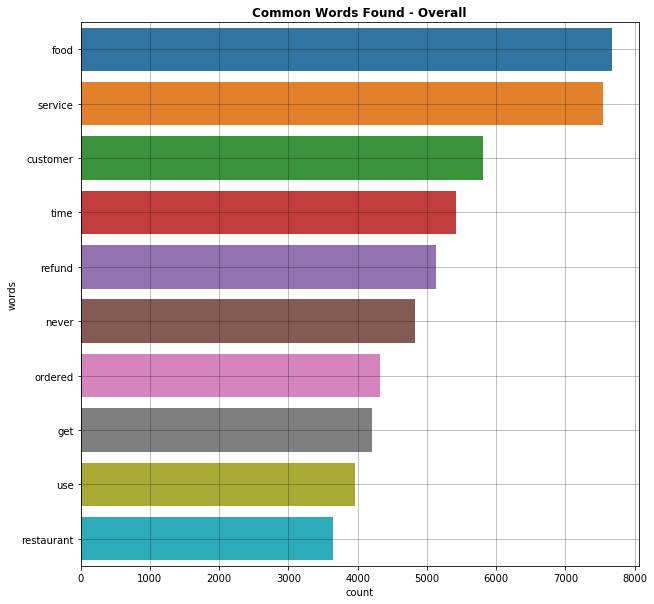

In [32]:
plot_most_common_words(base_df, n_most_common=10, text_col='Review_Merged')

In [38]:
def plot_wordcloud(input_df: pd.DataFrame,
                   text_col: str,
                   figsize=(10, 10)) -> None:
    """
    Generate a WordCloud plot based on the number of occurenences of words
    in a set documents
    """
    plt.figure(figsize=figsize)
    combined_text = ' '.join([x for x in input_df[text_col] if x is not None])
    wordcloud = WordCloud().generate(combined_text)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.show()

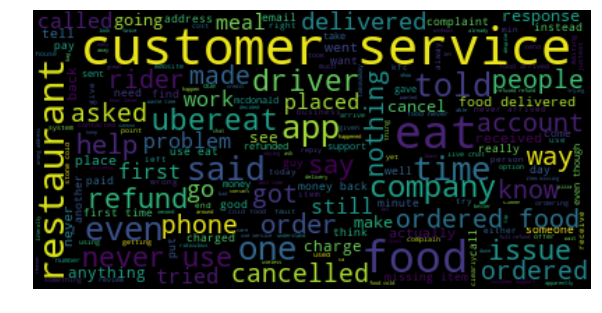

In [39]:
plot_wordcloud(base_df, text_col='Review_Merged')

By examining each word separately we are making the assumption that the words (and so their order) do not play any role into the general meaning of the text. Thus, we can go a step further and identify pairs of words (**bigrams**) that tend to appear next to each other.

In [40]:
from nltk.collocations import BigramCollocationFinder
from nltk import word_tokenize

from wordcloud import WordCloud


In [41]:
def compute_bigrams(input_df: pd.DataFrame, text_col: str) -> dict:
    """
    Calculate the number of occurences that a pair of words appear next to
    each other, and return a dictionary of pair of words - count.
    """
    combined_text = ' '.join([x for x in input_df[text_col]])

    finder = BigramCollocationFinder.from_words(word_tokenize(combined_text))

    bigrams_dict = {}
    for k, v in finder.ngram_fd.items():
        if len(k[0]) > 1 and len(k[1]) > 1 and "'s" not in k:
            bigrams_dict[k] = v
        else:
            continue
    return bigrams_dict

In [49]:
def plot_bigrams(input_df: pd.DataFrame, text_col: str, top_n: int, figsize=(10, 8)) -> None:

    bigrams_dict = compute_bigrams(input_df=input_df, text_col=text_col)
    bigrams_sorted = sorted(bigrams_dict.items(), key=lambda x: x[1], reverse=True)[0:top_n]
    bgram, counts = list(zip(*bigrams_sorted))
    bgstring = list(map(lambda txt: '-'.join(txt), bgram))

    plt.figure(figsize=figsize)
    g = sns.barplot(bgstring, counts, palette='muted')
    g.set_xticklabels(g.get_xticklabels(), rotation=80)
    plt.title(f'Top-{top_n} pairs of words that appear next to each other',
              fontweight='bold')
    plt.ylabel('Count')
    plt.grid(True, alpha=0.1, color='black')
    plt.show()

In [50]:
bigrams = compute_bigrams(base_df, text_col='Review_Merged')

In [51]:
pd.DataFrame(sorted(bigrams.items(), key=lambda item: item[1], reverse=True), columns=['Bigram', 'Count']).head(15)

,Bigram,Count
0,"(customer, service)",5398
1,"(never, use)",1169
2,"(ordered, food)",1070
3,"(missing, item)",724
4,"(food, delivered)",723
5,"(money, back)",702
6,"(first, time)",695
7,"(get, refund)",636
8,"(even, though)",589
9,"(never, arrived)",550


In [ ]:
plot_bigrams(input_df=base_df, text_col='Review_Merged', top_n=15)

From the bigrams plot we can infer that there are 3 main topics in the data:

1. Case where order arrived but an item was missing (e.g."missing item")
2. Case where items received very late ("cold food", "stone cold")
3. Case when the order never arrived ("food never", "never arrived")
    
We can also observe that the bigram "customer service" appears in the majority of the reviews. This is something expected, as in general reviews in TrustPilot for delivery companies tend to contain reviews about problems that the customers might have faced. 

Hence, it's regular when a customer facing an issue with their order, to contact the customer service of the company, independently of the nature of the issue (i.e. any of the 3 points we mentioned above). Queries about the customer service might not add a lot of information in the data as they seem to be part around in 1/3 of the total reviews. One option would be to remove these words from our analysis - by adding them in the stopwords list - but for now we will leave this set of words inside our dataset as it might provide us with some useful findings later.

In the next section we will finally get into the modelling part of the project. Based on our findings above and by leveraging a well known method for topic modelling (i.e. LDA), we will attempt to identify the different topics that exist inside the reviews.

<a id="lda"></a>
## Latent Dirichlet Allocation Model

In [24]:
# Gensim
from pprint import pprint
import gensim
import gensim.corpora as corpora

# Create Dictionary
id2word = corpora.Dictionary(base_df['Review_Lemma'])

# Create Corpus
texts = base_df['Review_Lemma']
# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# number of topics
num_topics = 5

# Build LDA model
lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                       id2word=id2word,
                                       num_topics=num_topics)
# Print the Keyword in the 5 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.022*"service" + 0.014*"customer" + 0.013*"food" + 0.010*"restaurant" + '
  '0.010*"time" + 0.010*"refund" + 0.010*"get" + 0.009*"would" + '
  '0.009*"ordered" + 0.008*"told"'),
 (1,
  '0.025*"food" + 0.016*"time" + 0.013*"service" + 0.011*"customer" + '
  '0.010*"refund" + 0.009*"use" + 0.009*"would" + 0.009*"company" + '
  '0.008*"never" + 0.007*"ordered"'),
 (2,
  '0.016*"service" + 0.015*"customer" + 0.014*"food" + 0.011*"time" + '
  '0.009*"refund" + 0.009*"would" + 0.007*"app" + 0.007*"restaurant" + '
  '0.006*"get" + 0.006*"hour"'),
 (3,
  '0.021*"food" + 0.016*"time" + 0.014*"service" + 0.011*"customer" + '
  '0.011*"restaurant" + 0.010*"get" + 0.010*"never" + 0.009*"refund" + '
  '0.008*"eats" + 0.007*"even"'),
 (4,
  '0.024*"food" + 0.018*"service" + 0.013*"customer" + 0.011*"never" + '
  '0.010*"hour" + 0.010*"time" + 0.010*"refund" + 0.008*"would" + '
  '0.008*"ordered" + 0.008*"get"')]


In [25]:
import pyLDAvis.gensim
import pickle 
import pyLDAvis

In [26]:
# Visualize the topics
pyLDAvis.enable_notebook()
LDAvis_data_filepath = os.path.join('./results/ldavis_prepared_'+ str(num_topics))

In [27]:
LDAvis_prepared = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)

In [28]:
LDAvis_prepared

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
4      0.000107 -0.000188       1        1  35.873786
0      0.004169 -0.018192       2        1  19.981812
2      0.010974 -0.000820       3        1  15.992972
1     -0.022501  0.001828       4        1  15.389800
3      0.007252  0.017373       5        1  12.761630, topic_info=            Term          Freq         Total Category  logprob  loglift
term                                                                   
44          time   7267.000000   7267.000000  Default  30.0000  30.0000
6           food  11940.000000  11940.000000  Default  29.0000  29.0000
324   restaurant   4988.000000   4988.000000  Default  28.0000  28.0000
10       service  10362.000000  10362.000000  Default  27.0000  27.0000
2       customer   7714.000000   7714.000000  Default  26.0000  26.0000
164         call   2332.000000   2332.000000  Default  25.0000  25.0000
28           get   4865.000000   4865.000000  Default  24.0000  24.0000
1254        eats   3000.000000   3000.000000  Default  23.0000  23.0000
39        refund   5945.000000   5945.000000  Default  22.0000  22.0000
77           use   4012.000000   4012.000000  Default  21.0000  21.0000
310      company   3388.000000   3388.000000  Default  20.0000  20.0000
5           even   3316.000000   3316.000000  Default  19.0000  19.0000
68         never   5234.000000   5234.000000  Default  18.0000  18.0000
50         wrong   1898.000000   1898.000000  Default  17.0000  17.0000
329        using   2182.000000   2182.000000  Default  16.0000  16.0000
4            eat   2334.000000   2334.000000  Default  15.0000  15.0000
82         would   4880.000000   4880.000000  Default  14.0000  14.0000
206    delivered   3490.000000   3490.000000  Default  13.0000  13.0000
66         money   3307.000000   3307.000000  Default  12.0000  12.0000
316         good   1232.000000   1232.000000  Default  11.0000  11.0000
163         back   2591.000000   2591.000000  Default  10.0000  10.0000
181          app   3254.000000   3254.000000  Default   9.0000   9.0000
243        phone   1820.000000   1820.000000  Default   8.0000   8.0000
612       minute   2576.000000   2576.000000  Default   7.0000   7.0000
107         late   1259.000000   1259.000000  Default   6.0000   6.0000
116         give   2176.000000   2176.000000  Default   5.0000   5.0000
318         like   1773.000000   1773.000000  Default   4.0000   4.0000
34           one   2866.000000   2866.000000  Default   3.0000   3.0000
1164    terrible   1235.000000   1235.000000  Default   2.0000   2.0000
338      arrived   1878.000000   1878.000000  Default   1.0000   1.0000
...          ...           ...           ...      ...      ...      ...
603         keep    170.595732    735.393593   Topic5  -6.1088   0.5976
894        price    107.001018    399.536320   Topic5  -6.5752   0.7413
238       number    237.745945   1166.317529   Topic5  -5.7769   0.4683
561           wo    137.262797    566.947987   Topic5  -6.3262   0.6404
744        waste    128.255060    526.026548   Topic5  -6.3941   0.6474
329        using    371.632277   2182.173450   Topic5  -5.3302   0.2886
243        phone    316.154127   1820.381226   Topic5  -5.4919   0.3082
116         give    356.701297   2176.560374   Topic5  -5.3712   0.2501
10       service   1088.062157  10362.439060   Topic5  -4.2559  -0.1951
2       customer    868.060555   7714.103899   Topic5  -4.4818  -0.1258
39        refund    714.112937   5945.488915   Topic5  -4.6770  -0.0606
206    delivered    482.850918   3490.247633   Topic5  -5.0684   0.0807
137        every    149.683704    716.771120   Topic5  -6.2396   0.4925
375          let    134.665334    632.961910   Topic5  -6.3453   0.5111
318         like    283.537726   1773.861168   Topic5  -5.6007   0.2252
50         wrong    294.339028   1898.549615   Topic5  -5.5634   0.1946
77           use    490.754959   4012.638055   Topi

In [17]:
# # this is a bit time consuming - make the if statement True
# # if you want to execute visualization prep yourself
if 1 == 1:
    LDAvis_prepared = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
    with open(LDAvis_data_filepath, 'wb') as f:
        pickle.dump(LDAvis_prepared, f)
# load the pre-prepared pyLDAvis data from disk
with open(LDAvis_data_filepath, 'rb') as f:
    LDAvis_prepared = pickle.load(f)
pyLDAvis.save_html(LDAvis_prepared, './results/ldavis_prepared_'+ str(num_topics) +'.html')
LDAvis_prepared

PermissionError: [Errno 13] Permission denied: './results/ldavis_prepared_5'